## Importando bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE

## Carregando dataset

In [2]:
df_dados = pd.read_csv('./train.csv')

df_dados.head(5)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


In [4]:
df_dados.describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


## Tratamento dos dados

In [5]:
df_dados['Dates'] = pd.to_datetime(df_dados['Dates'])

df_dados.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


## Visualizando os dados

In [6]:
def show_report_feature(data, column):
    quant_registros = data[column].nunique()
    
    print(f'Quantidade de valores únicos: {data[column].nunique()}')
    if quant_registros <= 50:     
        print(f'Quais são os valores únicos: {data[column].unique()}')
        print(f'Quantidade de valores nulos: {data[column].isnull().sum()}')
        print(f'Quantidade por opção de coluna: \n{data[column].value_counts()}')
    else:
        print(f'Quais são os valores únicos: {data[column].unique()[:50]}')
        print(f'Quantidade de valores nulos: {data[column].isnull().sum()}')
        print(f'Quantidade por opção de coluna: \n{data[column].value_counts()[:50]}')

### Analisando Categoria

In [7]:
show_report_feature(df_dados, 'Category')

Quantidade de valores únicos: 39
Quais são os valores únicos: ['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' 'DISORDERLY CONDUCT' 'ARSON'
 'FAMILY OFFENSES' 'LIQUOR LAWS' 'BRIBERY' 'EMBEZZLEMENT' 'SUICIDE'
 'LOITERING' 'SEX OFFENSES NON FORCIBLE' 'EXTORTION' 'GAMBLING'
 'BAD CHECKS' 'TREA' 'RECOVERED VEHICLE' 'PORNOGRAPHY/OBSCENE MAT']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRA

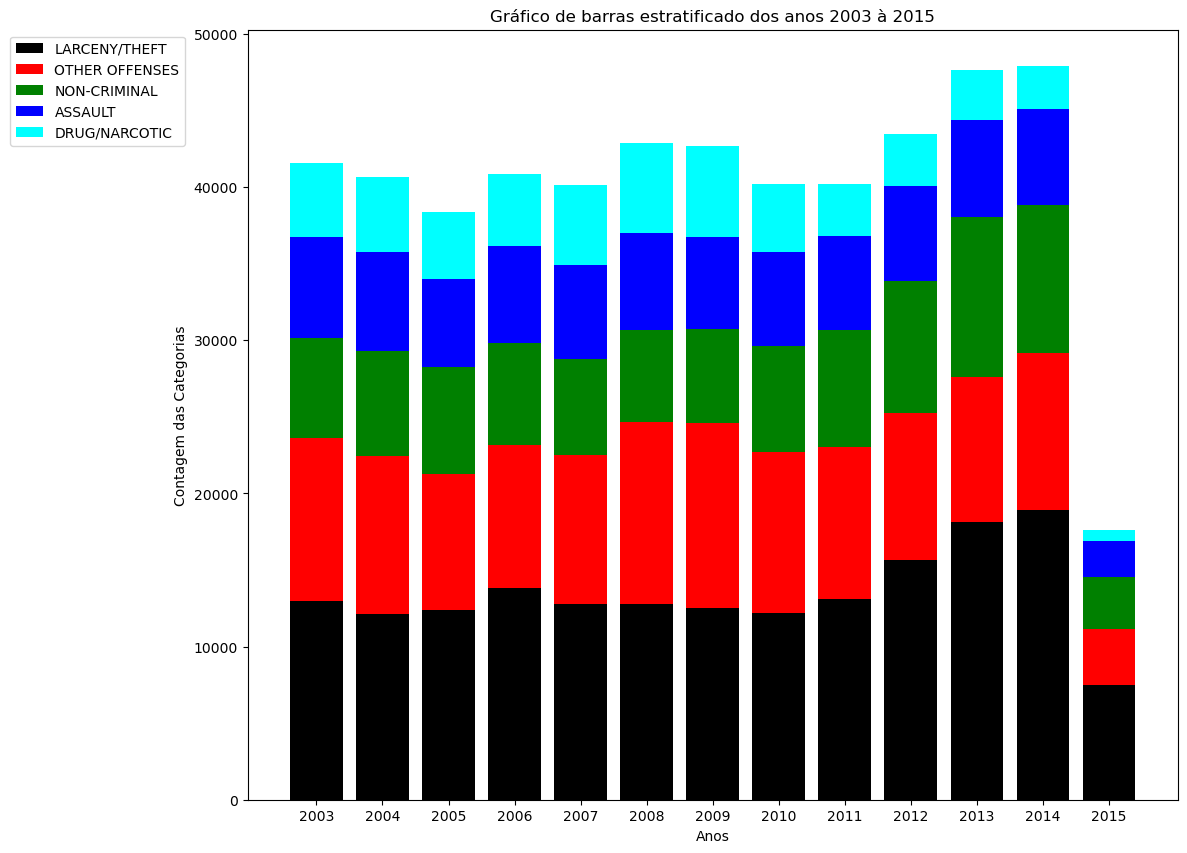

In [8]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]
anos = sorted(list(dict.fromkeys([d.date().year for d in df_dados['Dates']])))

dictBarplotCategory = dict()

for category in listaCategoryTop5:
    arrayAux = list()
    
    for ano in anos:
        
        selecao = (df_dados['Dates'] >= str(ano)+'-01-01') & (df_dados['Dates'] <= str(ano+1)+'-01-01')
        dadosAux = df_dados[selecao]
                
        somaCategory = dadosAux[dadosAux['Category'].str.startswith(category)]['Category'].count()
        
        arrayAux.append(somaCategory)
        
    dictBarplotCategory[category] = arrayAux
    
plt.figure(figsize=(12, 10))

soma = np.zeros(anos[-1] - anos[0] + 1)

colors=['black', 'red', 'green', 'blue', 'cyan', 'magenta', 'yellow', 'pink', 'orange', 'purple', '#237698', '#AA2498', '#CCDD55',
       '#AA5312', '#866732', '#AA5800', '#777', '#3377EE', '#2F9', '#6C8']
contColor = 0

for category in dictBarplotCategory.keys():
    plt.bar(anos, np.array(dictBarplotCategory[category]), bottom = np.array(soma), color=colors[contColor])
    soma = np.array(dictBarplotCategory[category]) + soma
    
    contColor += 1
    
plt.xticks(anos)

plt.xlabel("Anos")
plt.ylabel("Contagem das Categorias")

plt.legend(listaCategoryTop5, loc = 'best', bbox_to_anchor=(-0.06, 1))
plt.title(f"Gráfico de barras estratificado dos anos {anos[0]} à {anos[-1]}")

plt.show()

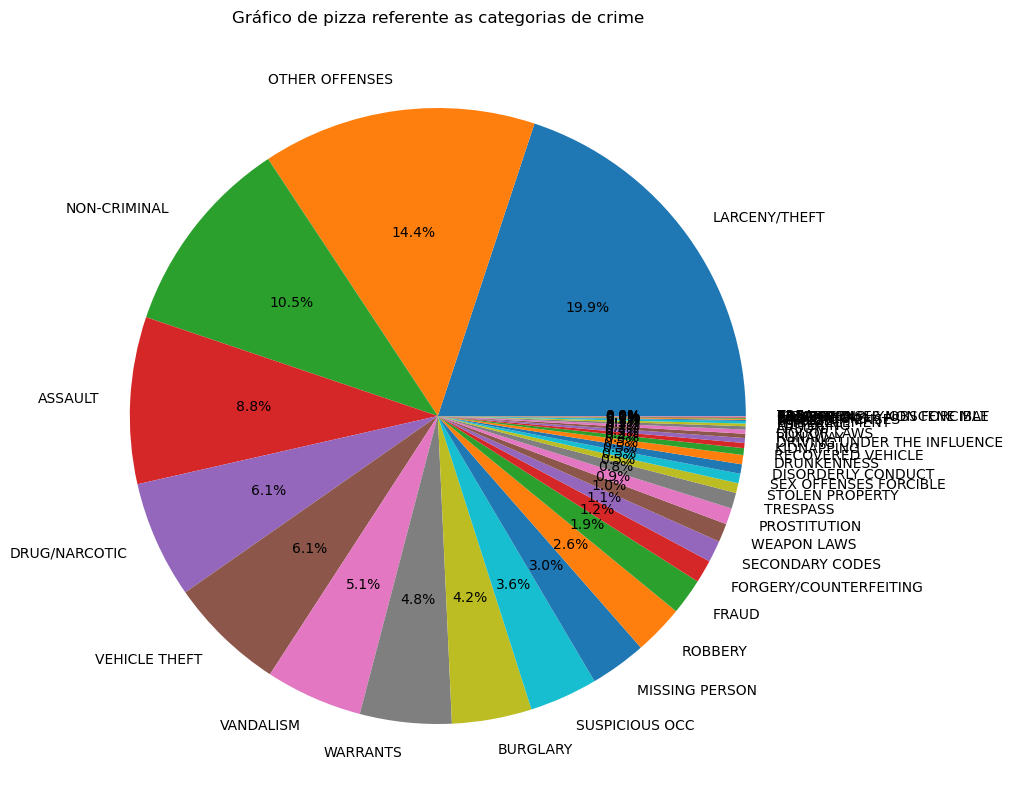

In [9]:
category_value_counts = df_dados['Category'].value_counts()

labels = category_value_counts.index.tolist()
values = category_value_counts.values.tolist()

plt.figure(figsize=(12,10))
plt.pie(values, labels = labels, autopct='%1.1f%%')

plt.title("Gráfico de pizza referente as categorias de crime")

plt.show()

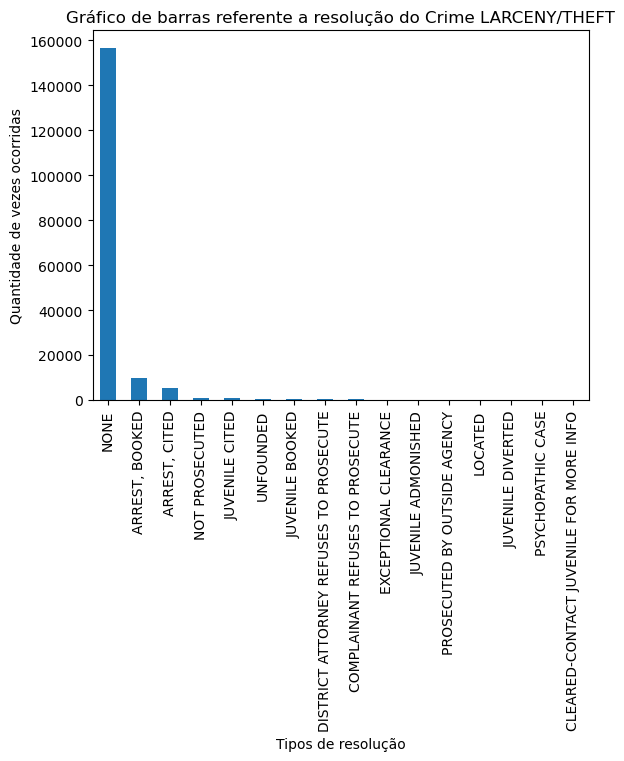

In [10]:
df_dados[df_dados['Category'] == 'LARCENY/THEFT']['Resolution'].value_counts().plot(kind='bar')

plt.title("Gráfico de barras referente a resolução do Crime LARCENY/THEFT")
plt.xlabel("Tipos de resolução")
plt.ylabel("Quantidade de vezes ocorridas")

plt.show()

### Analisando descrição

In [11]:
show_report_feature(df_dados, 'Descript')

Quantidade de valores únicos: 879
Quais são os valores únicos: ['WARRANT ARREST' 'TRAFFIC VIOLATION ARREST'
 'GRAND THEFT FROM LOCKED AUTO' 'GRAND THEFT FROM UNLOCKED AUTO'
 'STOLEN AUTOMOBILE' 'PETTY THEFT FROM LOCKED AUTO'
 'MISCELLANEOUS INVESTIGATION' 'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES'
 'FOUND PROPERTY' 'ROBBERY, ARMED WITH A KNIFE'
 'AGGRAVATED ASSAULT WITH BODILY FORCE' 'TRAFFIC VIOLATION'
 'ROBBERY, BODILY FORCE' 'STAY AWAY OR COURT ORDER, NON-DV RELATED'
 'LOST PROPERTY' 'ATTEMPTED THEFT FROM LOCKED VEHICLE'
 'CIVIL SIDEWALKS, CITATION' 'MALICIOUS MISCHIEF, VANDALISM'
 'SUSPICIOUS PACKAGE' 'AIDED CASE, MENTAL DISTURBED'
 'PETTY THEFT SHOPLIFTING' 'PROBATION VIOLATION'
 'STAY AWAY ORDER VIOLATION, DV RELATED'
 'DRIVERS LICENSE, SUSPENDED OR REVOKED' 'STOLEN MOTORCYCLE'
 'GRAND THEFT FROM PERSON' 'BURGLARY, VEHICLE (ARREST MADE)'
 'ATTEMPTED ROBBERY ON THE STREET WITH BODILY FORCE'
 'PETTY THEFT FROM A BUILDING' 'INVESTIGATIVE DETENTION'
 'GRAND THEFT OF PROPERTY' 'STOLE

### Analisando dia da semana

In [12]:
show_report_feature(df_dados, 'DayOfWeek')

Quantidade de valores únicos: 7
Quais são os valores únicos: ['Wednesday' 'Tuesday' 'Monday' 'Sunday' 'Saturday' 'Friday' 'Thursday']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64


In [13]:
def porcentagem_dayOfWeek_category(dados):
    dados['Porcentagem'] = dados['Quantidade'] / df_dados[df_dados['DayOfWeek'] == dados['DayOfWeek']]['DayOfWeek'].count()
    
    return dados

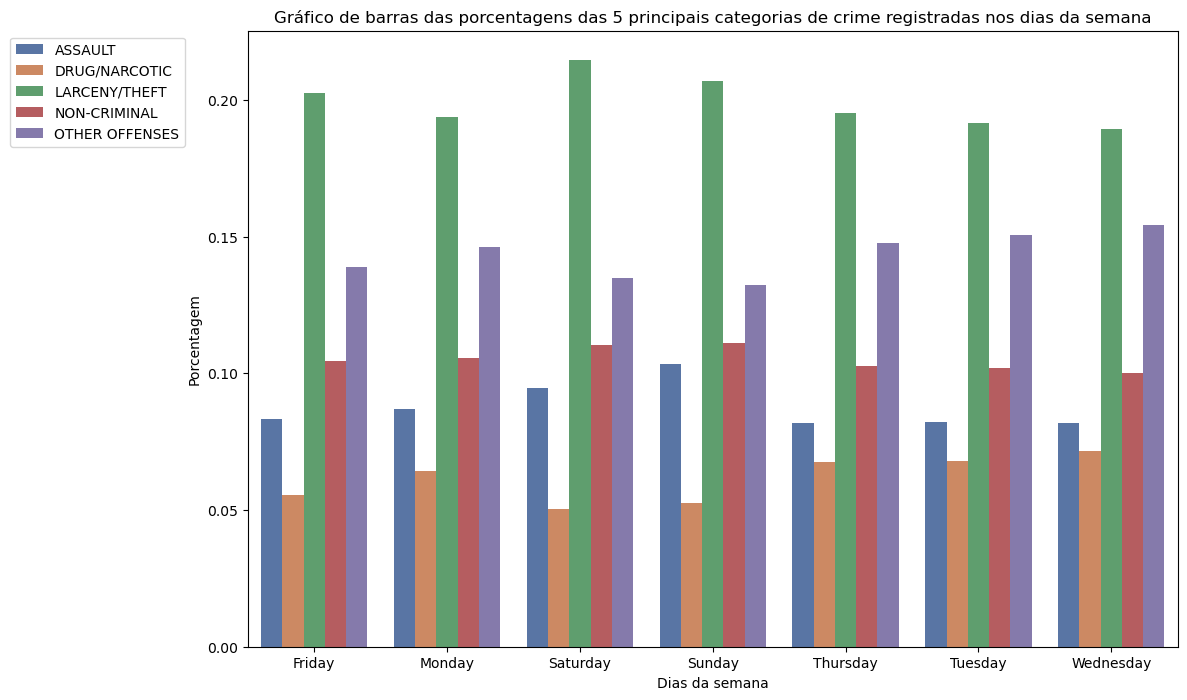

In [14]:
listaCategoryTop5 = df_dados['Category'].value_counts().index.tolist()[:5]

df_dados_filter = df_dados[df_dados['Category'].isin(listaCategoryTop5)]

df_dados_agrupados = df_dados_filter.groupby(['DayOfWeek', 'Category']).size().to_frame('Quantidade').reset_index()
df_dados_agrupados = df_dados_agrupados.apply(porcentagem_dayOfWeek_category, axis = 1)

plt.figure(figsize=(12,8))
sns.barplot(x='DayOfWeek', y='Porcentagem', hue='Category', data=df_dados_agrupados, palette="deep")

plt.xlabel("Dias da semana")
plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title("Gráfico de barras das porcentagens das 5 principais categorias de crime registradas nos dias da semana")

plt.show()

### Analisando endereço

In [15]:
show_report_feature(df_dados, 'Address')

Quantidade de valores únicos: 23228
Quais são os valores únicos: ['OAK ST / LAGUNA ST' 'VANNESS AV / GREENWICH ST'
 '1500 Block of LOMBARD ST' '100 Block of BRODERICK ST'
 '0 Block of TEDDY AV' 'AVALON AV / PERU AV' 'KIRKWOOD AV / DONAHUE ST'
 '600 Block of 47TH AV' 'JEFFERSON ST / LEAVENWORTH ST'
 '0 Block of ESCOLTA WY' 'TURK ST / JONES ST' 'FILLMORE ST / GEARY BL'
 '200 Block of WILLIAMS AV' '0 Block of MENDELL ST' 'EDDY ST / JONES ST'
 'GODEUS ST / MISSION ST' 'MENDELL ST / HUDSON AV' '100 Block of JONES ST'
 '200 Block of EVELYN WY' '1600 Block of VALENCIA ST'
 'FILLMORE ST / LOMBARD ST' '300 Block of OFARRELL ST'
 '2000 Block of BUSH ST' '500 Block of COLLEGE AV' '19TH AV / SANTIAGO ST'
 '2000 Block of 41ST AV' '1300 Block of WEBSTER ST'
 '400 Block of CASTRO ST' '1500 Block of FILLMORE ST'
 '1600 Block of WEBSTER ST' 'KING ST / 3RD ST' 'VALLEJO ST / BUCHANAN ST'
 'CALIFORNIA ST / BUCHANAN ST' '1400 Block of HOLLOWAY AV'
 '0 Block of WINDING WY' '700 Block of MARKET ST'
 '1600 Bl

## Analisando latitude e longitude

In [36]:
df_dados[df_dados['Y'] > 85]

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
660485,2005-12-30 17:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,TENDERLOIN,NONE,5THSTNORTH ST / OFARRELL ST,-120.5,90.0
660711,2005-12-30 00:34:00,ASSAULT,INFLICT INJURY ON COHABITEE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
660712,2005-12-30 00:34:00,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Friday,BAYVIEW,"ARREST, BOOKED",JAMESLICKFREEWAY HY / SILVER AV,-120.5,90.0
661106,2005-12-29 00:07:00,NON-CRIMINAL,"AIDED CASE, MENTAL DISTURBED",Thursday,TENDERLOIN,PSYCHOPATHIC CASE,5THSTNORTH ST / EDDY ST,-120.5,90.0
666430,2005-11-30 11:25:00,OTHER OFFENSES,TRAFFIC VIOLATION,Wednesday,TENDERLOIN,"ARREST, CITED",5THSTNORTH ST / ELLIS ST,-120.5,90.0
...,...,...,...,...,...,...,...,...,...
844995,2003-06-11 08:49:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Wednesday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
845842,2003-06-09 09:25:00,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Monday,INGLESIDE,"ARREST, CITED",JAMES LICK FREEWAY HY / CESAR CHAVEZ ST,-120.5,90.0
852880,2003-05-02 01:00:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Friday,SOUTHERN,COMPLAINANT REFUSES TO PROSECUTE,3RD ST / JAMES LICK FREEWAY HY,-120.5,90.0
857248,2003-04-14 16:30:00,ROBBERY,"ROBBERY ON THE STREET, STRONGARM",Monday,BAYVIEW,COMPLAINANT REFUSES TO PROSECUTE,GILMAN AV / FITCH ST,-120.5,90.0


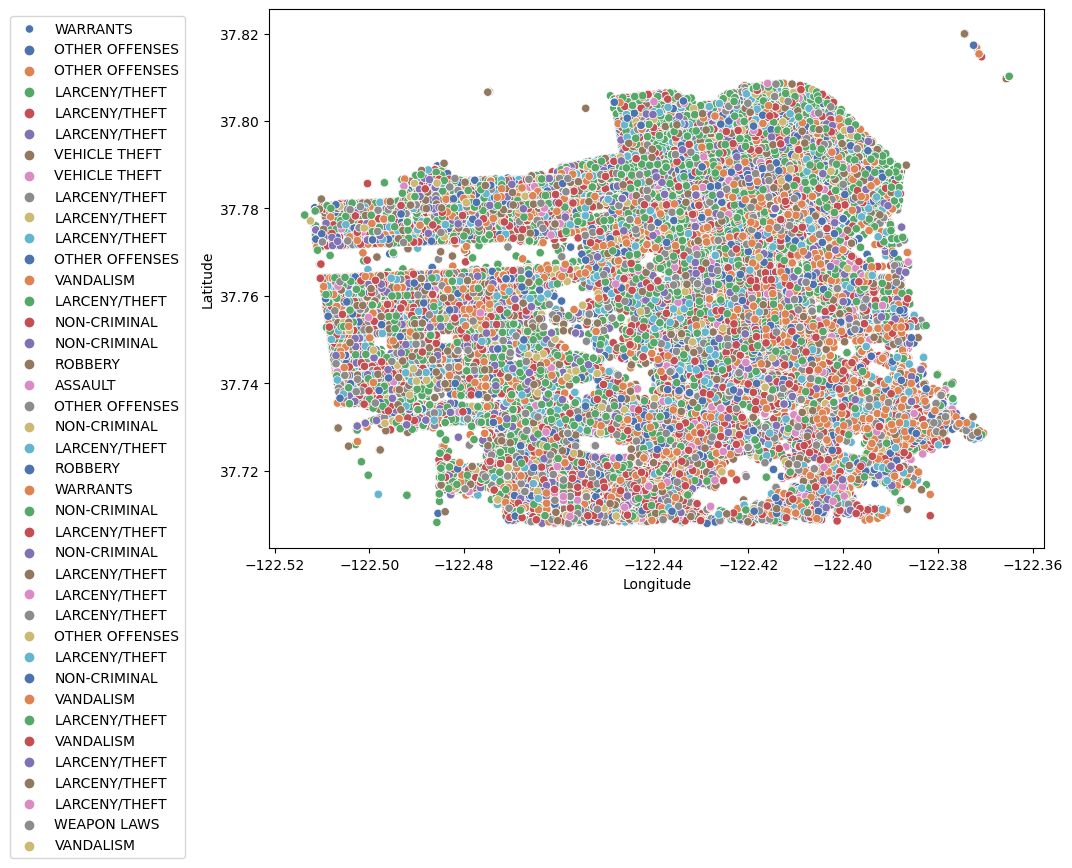

In [32]:
plt.figure(figsize=(10, 7))

df_dados_filter = df_dados[df_dados['Y'] < 85]

sns.scatterplot(df_dados_filter, x = df_dados_filter['X'], y = df_dados_filter['Y'], hue = df_dados_filter['Category'], palette="deep")

plt.legend(df_dados['Category'], loc = 'best', bbox_to_anchor=(-0.1, 1))

plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

### Analisando nome do distrito do departamento de polícia

In [18]:
show_report_feature(df_dados, 'PdDistrict')

Quantidade de valores únicos: 10
Quais são os valores únicos: ['NORTHERN' 'PARK' 'INGLESIDE' 'BAYVIEW' 'RICHMOND' 'CENTRAL' 'TARAVAL'
 'TENDERLOIN' 'MISSION' 'SOUTHERN']
Quantidade de valores nulos: 0
Quantidade por opção de coluna: 
SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64


In [19]:
def porcentagem_categoria_PdDistrict(dados):
    dados['Porcentagem'] = dados['Quantidade'] / df_dados[df_dados['PdDistrict'] == dados['PdDistrict']]['PdDistrict'].count()
    
    return dados

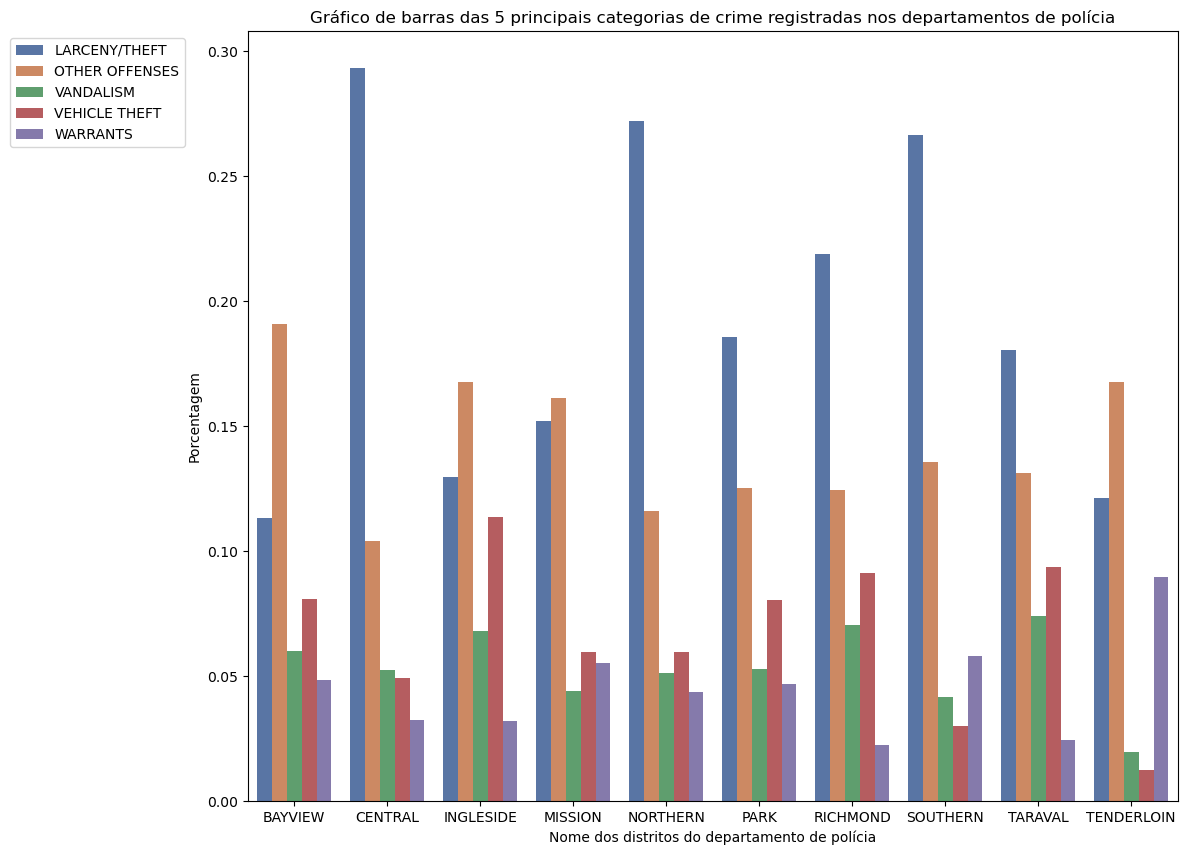

In [20]:
listaCategoryTop5 = df_dados['Category'].unique().tolist()[:5]

df_dados_filter = df_dados[df_dados['Category'].isin(listaCategoryTop5)]

df_dados_agrupados = df_dados_filter.groupby(['PdDistrict', 'Category']).size().to_frame('Quantidade').reset_index()
df_dados_agrupados = df_dados_agrupados.apply(porcentagem_categoria_PdDistrict, axis = 1)

plt.figure(figsize=(12,10))
sns.barplot(x='PdDistrict', y='Porcentagem', hue='Category', data=df_dados_agrupados, palette="deep")

plt.xlabel("Nome dos distritos do departamento de polícia")
plt.legend(loc = 'best', bbox_to_anchor=(-0.06, 1))

plt.title("Gráfico de barras das 5 principais categorias de crime registradas nos departamentos de polícia")

plt.show()

In [21]:
df_dados.groupby('PdDistrict')['Category'].value_counts()

PdDistrict  Category                 
BAYVIEW     OTHER OFFENSES               17053
            LARCENY/THEFT                10119
            ASSAULT                       9857
            VEHICLE THEFT                 7219
            NON-CRIMINAL                  6099
                                         ...  
TENDERLOIN  GAMBLING                        12
            RUNAWAY                          9
            EXTORTION                        8
            SEX OFFENSES NON FORCIBLE        5
            PORNOGRAPHY/OBSCENE MAT          1
Name: Category, Length: 382, dtype: int64

df_features = df_dados.drop(columns=['Category', 'Resolution', 'Descript', 'Dates', 'Address'])

df_features = pd.get_dummies(df_features, columns=['PdDistrict', 'DayOfWeek'])

target = df_dados['Category']

model = TSNE(n_components=2, learning_rate='auto')
array_red = model.fit_transform(df_features)

df_tsne = pd.DataFrame(array_red, columns=['com1', 'com2'])

df_tsne['target'] = target

sns.scatterplot(data=df_tsne, x='com1', y='com2', hue='target', palette='deep')

plt.show()

In [22]:
# Convert it to a GeoDataFrame by transforming the Latitude/Longitude coordinates 
#loc_crs = {'init': 'epsg:4326'}
#loc_geom = [Point(xy) for xy in zip(MinMaxScaler.fit_transform(df_dados['X']), MinMaxScaler.fit_transform(df_dados['Y']))]
#geo_df = gpd.GeoDataFrame(df_dados, crs=loc_crs, geometry=loc_geom)

# Plot the GeoDataFrame
#geo_df.plot()

In [23]:
min_max_scaler = MinMaxScaler()
stardard_scaler = StandardScaler()

df_dados_train = df_dados.drop(['Dates', 'Address'], axis = 1)
df_dados_train = pd.get_dummies(df_dados_train)

df_dados_train.head()

X = df_dados_train.values

dictCategory = df_dados['Category'].unique()

wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(arrayProporcao)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS')
plt.show()

kmeans = KMeans(n_clusters=4, init='random', random_state=5).fit(X)

plt.figure(figsize=(15,8))

var1 = 2
var2 = 100

cont = 0

plt.scatter(X[:,var1], X[:,var2], s=100, c=kmeans.labels_, cmap='rainbow')
for label in dictCategory:
    plt.annotate(label, (X[cont, var1], X[cont, var2]), fontsize=12)
    cont += 1
#plt.scatter(kmeans.cluster_centers_[:, var1], kmeans.cluster_centers_[:, var2], s=300, c='red', label="Centroids")
#plt.legend()
plt.show()